In [1]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
import networkx as nx


from netgraph import Graph, InteractiveGraph

from networkx.algorithms.community import girvan_newman, modularity_max, louvain_communities

from visu_utils import *

# white grid
sns.set_style("whitegrid")

%load_ext autoreload
%autoreload 2


PREFIX = "mteb_ds"
df = pd.read_csv('exported_data/normalized_13.df')


df = text_embeddings_metadata_results_preprocessing(df, models=MODELS_MAIN_EXPES)
METRIC = "I(X_1->X_2)/d_2"



In [2]:

classifcation_df = pd.read_csv('exported_data/classification_many_3_avg.csv')

classifcation_df['model'] = classifcation_df['model'].apply(lambda x: eval(x)[0])

rankings = make_rankings_table(classifcation_df, df, METRIC, q=0.5)

rankings['model'] = map_short(rankings['model'].tolist())


In [3]:


print(len(df['model_1'].unique().tolist()))

34


In [4]:

print(" ".join([f'"{m}"' for m in df['model_1'].unique().tolist()]))



"BAAI/bge-base-en-v1.5" "GritLM/GritLM-7B" "NousResearch/Llama-2-7b-hf" "Salesforce/SFR-Embedding-Mistral" "SmartComponents/bge-micro-v2" "TaylorAI/gte-tiny" "WhereIsAI/UAE-Large-V1" "avsolatorio/GIST-Embedding-v0" "google/gemma-2b-it" "google/gemma-7b-it" "infgrad/stella-base-en-v2" "intfloat/e5-large-v2" "intfloat/e5-small" "intfloat/multilingual-e5-small" "izhx/udever-bloom-560m" "jamesgpt1/sf_model_e5" "jspringer/echo-mistral-7b-instruct-lasttoken" "llmrails/ember-v1" "princeton-nlp/sup-simcse-bert-base-uncased" "sentence-transformers/LaBSE" "sentence-transformers/all-MiniLM-L6-v2" "sentence-transformers/all-distilroberta-v1" "sentence-transformers/all-mpnet-base-v2" "sentence-transformers/allenai-specter" "sentence-transformers/average_word_embeddings_glove.6B.300d" "sentence-transformers/average_word_embeddings_komninos" "sentence-transformers/gtr-t5-base" "sentence-transformers/gtr-t5-large" "sentence-transformers/gtr-t5-xl" "sentence-transformers/msmarco-bert-co-condensor" "sen

/tmp/ipykernel_366383/1602465474.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax['ranking_classif'].set_yticklabels(ax['ranking_classif'].get_yticklabels(), fontsize=18, fontweight='bold')


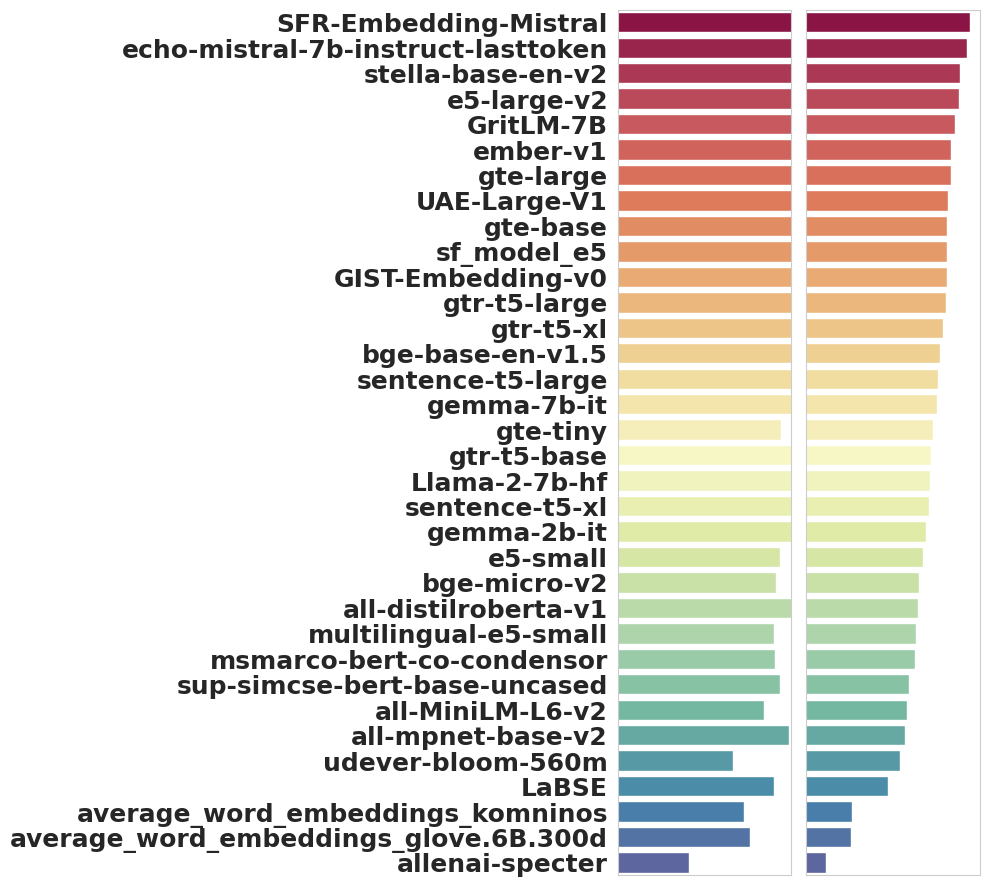

In [5]:


fig, ax = plt.subplot_mosaic([['ranking_classif', 'ranking_informativeness']], sharey=True, sharex=False, figsize=(10, 9))
# hatches = ['/', '\\', '|', '-', '+', 'x', 'o', 'O', '.', '*']*2

informativeness_ranking = rankings[rankings['ranking'] == 'informativeness']
classification_ranking = rankings[rankings['ranking'] == 'classification']

# rank both by informativeness
ordered_models = informativeness_ranking.sort_values('value', ascending=False)['model'].values

spectral_cmap = sns.color_palette("Spectral", as_cmap=True)
model_colors = {m : k for k, m in enumerate(ordered_models)}
# normalize colors
model_colors = {m: spectral_cmap(k / len(model_colors)) for m, k in model_colors.items()}


informativeness_ranking = informativeness_ranking.set_index('model').loc[ordered_models].reset_index()
classification_ranking = classification_ranking.set_index('model').loc[ordered_models].reset_index()

sns.barplot(data=informativeness_ranking, y='model', x='value', ax=ax['ranking_informativeness'], palette=model_colors, orient='h', hue='model')
ax['ranking_informativeness'].set_xlim(0.35, 0.6)
# remove ticks
ax['ranking_informativeness'].set_xticks([])
ax['ranking_informativeness'].set_xlabel('')
ax['ranking_informativeness'].set_ylabel('')


sns.barplot(data=classification_ranking, y='model', x='value', ax=ax['ranking_classif'], palette=model_colors, orient='h', hue='model')
ax['ranking_classif'].set_xlim(0.5, 0.70)
# remove ticks
ax['ranking_classif'].set_xticks([])
ax['ranking_classif'].set_xlabel('')
ax['ranking_classif'].set_ylabel('')

ax['ranking_classif'].set_yticklabels(ax['ranking_classif'].get_yticklabels(), fontsize=18, fontweight='bold')

fig.tight_layout()

path = Path(f"../../../papers/emir-embedding-comparison/fig/nlp/{PREFIX}_barplot_rankings_mytasks_{sanitize_metric_name(METRIC)}.pdf")
path.parent.mkdir(parents=True, exist_ok=True)
fig.savefig(path, bbox_inches='tight')




Index(['model', 'value', 'rank', 'ranking', 'community'], dtype='object')


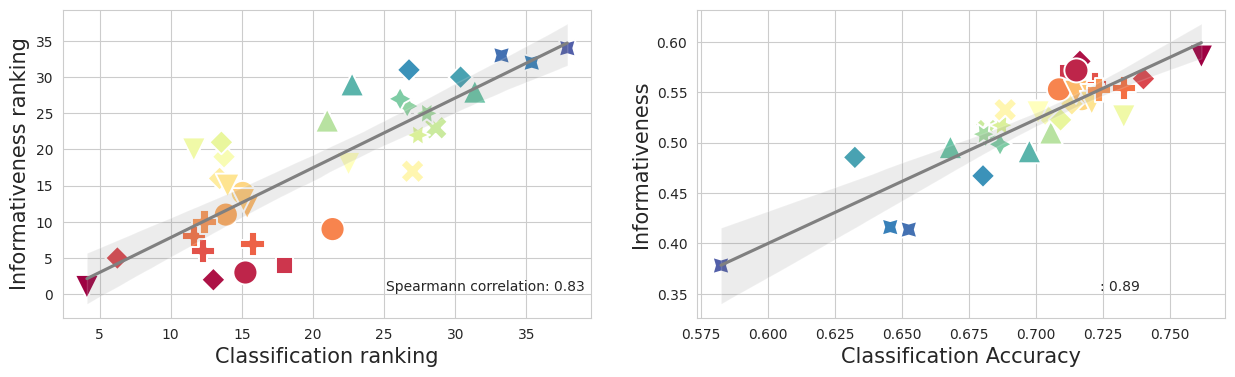

In [6]:
print(rankings.columns)

fig, ax = plt.subplots(ncols=2, figsize=(15, 4))

scattering_pivot = rankings.groupby(['model', 'ranking', 'community']).first().reset_index().pivot(columns='ranking', values='rank', index=['model', 'community']) # classification, informativeness

# fillna
scattering_pivot = scattering_pivot.fillna(0)

sns.scatterplot(data=scattering_pivot, x='classification', y='informativeness', ax=ax[0], hue="model", style="community", legend=False, s=300, palette=model_colors)

sns.regplot(data=scattering_pivot, x='classification', y='informativeness', ax=ax[0], scatter=False, color='gray')

# rename labels
ax[0].set_xlabel('Classification ranking', fontsize=15)
ax[0].set_ylabel('Informativeness ranking', fontsize=15)

# annotate with spearmann correlation
corr = scattering_pivot.corr().loc['classification', 'informativeness']
ax[0].annotate(f"Spearmann correlation: {corr:.2f}", (0.8, 0.1), xycoords='axes fraction', ha='center', va='center')



###########
# Plot correlations with accuracy
###########

scattering_pivot = rankings.groupby(['model', 'ranking', 'community']).first().reset_index().pivot(columns='ranking', values='value', index=['model', 'community']) # classification, informativeness

# fillna
scattering_pivot = scattering_pivot.fillna(0)

sns.scatterplot(data=scattering_pivot, x='classification', y='informativeness', ax=ax[1], hue="model", style="community", legend=False, s=300, palette=model_colors)

sns.regplot(data=scattering_pivot, x='classification', y='informativeness', ax=ax[1], scatter=False, color='gray')

# rename labels
ax[1].set_xlabel('Classification Accuracy', fontsize=15)
ax[1].set_ylabel('Informativeness', fontsize=15)

# annotate with spearmann correlation
corr = scattering_pivot.corr().loc['classification', 'informativeness']
ax[1].annotate(f": {corr:.2f}", (0.8, 0.1), xycoords='axes fraction', ha='center', va='center')


PREFIX = "mteb_ds"
df = pd.read_csv('exported_data/normalized_13.df')


path = Path(f"../../../papers/emir-embedding-comparison/fig/nlp/{PREFIX}_scatterplot_rankings_mytasks_{sanitize_metric_name(METRIC)}.pdf")
path.parent.mkdir(parents=True, exist_ok=True)
fig.savefig(path, bbox_inches='tight')





['CroissantCool', 'CroissantLLMBase', 'gemma-7b-it', 'gemma-7b', 'gemma-2b-it', 'gemma-2b', 'SFR-Embedding-Mistral', 'UAE-Large-V1', 'sf_model_e5', 'average_word_embeddings_glove.6B.300d', 'allenai-specter', 'gtr-t5-base', 'gtr-t5-large', 'gtr-t5-xl', 'LaBSE', 'echo-mistral-7b-instruct-lasttoken', 'e5-small', 'e5-large-v2', 'udever-bloom-560m', 'Llama-2-7b-hf', 'stella-base-en-v2']


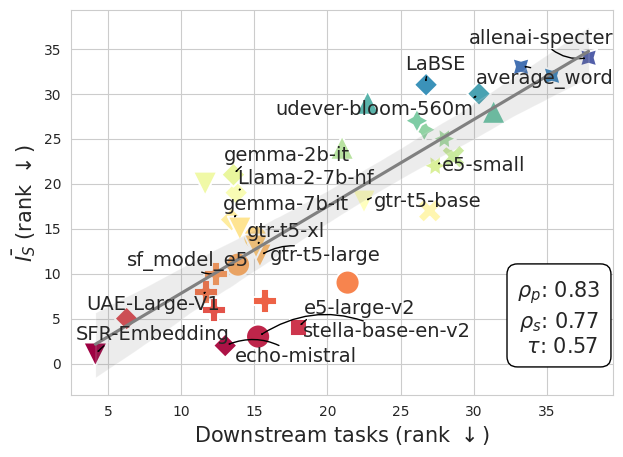

In [37]:
from adjustText import adjust_text
def shorten_more(text):
    if len(text) > 20:
        if len(text.split('_')) > 1:
            text = "_".join(text.split('_')[:2])
        elif len(text.split('/')) > 1:
            text = "/".join(text.split('/')[:2])
        elif len(text.split('-')) > 1:
            text = "-".join(text.split('-')[:2])

    return text


fig, ax = plt.subplots(figsize=(7, 5))

scattering_pivot = rankings.groupby(['model', 'ranking', 'community']).first().reset_index().pivot(columns='ranking', values='rank', index=['model', 'community']) # classification, informativeness
scattering_pivot_values = rankings.groupby(['model', 'ranking', 'community']).first().reset_index().pivot(columns='ranking', values='rank', index=['model', 'community']) # classification, informativeness

# fillna
scattering_pivot = scattering_pivot.fillna(0)

sns.scatterplot(data=scattering_pivot, x='classification', y='informativeness', ax=ax, hue="model", style="community", legend=False, s=300, palette=model_colors)

sns.regplot(data=scattering_pivot, x='classification', y='informativeness', ax=ax, scatter=False, color='gray')

# rename labels
ax.set_xlabel('Downstream tasks (rank $\\downarrow$)', fontsize=15)
ax.set_ylabel('$\\bar{I_{S}}$ (rank $\\downarrow$)', fontsize=15)

# annotate with spearmann correlation
spearmann = scattering_pivot_values.corr('spearman').loc['classification', 'informativeness']
pearson = scattering_pivot_values.corr('pearson').loc['classification', 'informativeness']
kendall = scattering_pivot_values.corr('kendall').loc['classification', 'informativeness']

# ax.annotate(f"Spearmann correlation: {corr:.2f}", (0.8, 0.1), xycoords='axes fraction', ha='center', va='center')
ax.annotate(f"$\\rho_p$: {pearson:.2f}\n$\\rho_s$: {spearmann:.2f}\n $\\tau$: {kendall:.2f}", (0.90, 0.2), xycoords='axes fraction', ha='center', va='center', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'), fontsize=15)

# Annotate model names
to_display = ["/".join(m.split('/')[-1:]) for m in TO_DISPLAY_GRAPH]
texts = []
print(to_display)
for model, row in scattering_pivot.iterrows():
    if model[0] in to_display:
        text = ax.text(row['classification'], row['informativeness'], shorten_more(model[0]), fontsize=14, ha='center', va='center')
        texts.append(text)

    
adjust_text(texts, arrowprops=dict(arrowstyle="->", color='black', lw=1, connectionstyle="arc3,rad=0.3"))



path = Path(f"../../../papers/emir-embedding-comparison/fig/nlp/{PREFIX}_scatterplot_rankings_only_mytasks_{sanitize_metric_name(METRIC)}.pdf")
path.parent.mkdir(parents=True, exist_ok=True)
fig.savefig(path, bbox_inches='tight')


In [8]:
# barplot of performance by community

rankings_per_task = make_rankings_table(classifcation_df, df, METRIC, aggrefate_tasks=False)

rankings_per_task = rankings_per_task[['model', 'dataset', 'value', 'ranking', 'rank', 'community']]




KeyError: "['I(X_1->X_2)/d_2'] not in index"

In [ ]:

# select all not NaN datasets
rankings_per_task_classif = rankings_per_task[~rankings_per_task['dataset'].isna()]
informativeness = rankings_per_task[rankings_per_task['ranking'] == 'informativeness']

correlation_table = []
for dataset in rankings_per_task_classif['dataset'].unique():
    print(dataset)
    selected_ds_classif = rankings_per_task_classif[rankings_per_task_classif['dataset'] == dataset]
    
    temp = pd.concat([selected_ds_classif, informativeness])
    
    # pivot table, ranking
    temp_values = temp.pivot(columns='ranking', values='value', index=['model', 'community'])
    temp_ranking = temp.pivot(columns='ranking', values='rank', index=['model', 'community'])
    
    
    correlation_table.append({
        'dataset': dataset,
        'Pearson': temp_values.corr().loc['classification', 'informativeness'],
        'Spearmann': temp_ranking.corr().loc['classification', 'informativeness'],
        'Kendall': temp_values.corr(method='kendall').loc['classification', 'informativeness'],
    })
    
correlation_table = pd.DataFrame(correlation_table)

In [ ]:

classifcation_df = pd.read_csv('exported_data/classification_many_3_avg.csv')

classifcation_df['model'] = classifcation_df['model'].apply(lambda x: eval(x)[0])

community_per_task = make_rankings_table(classifcation_df, df, METRIC, q=0.5, aggrefate_tasks=False)

community_per_task['model'] = map_short(community_per_task['model'].tolist())

community_per_task = community_per_task[['dataset', 'model', 'value', 'rank', 'ranking', 'community']]


In [ ]:
# keep only ranking = classification



sns.set(font_scale=1.1)
_community_per_task = community_per_task[community_per_task['ranking'] == 'classification']
_community_per_task = _community_per_task[~_community_per_task['dataset'].isin(['imdb', 'clinc_oos;plus', 'ag_news'])]
_community_per_task = _community_per_task[~_community_per_task['dataset'].str.contains('tweet')]
# _community_per_task = _community_per_task[~_community_per_task['dataset'].str.contains('emotion')]
# remove imdb and clinc_oos;plus 
_community_per_task = _community_per_task.sort_values(['dataset','community'], ascending=False)
_community_per_task['dataset'] = _community_per_task['dataset'].apply(lambda x: x.replace(';', '/'))

sns.set_style("whitegrid")

g = sns.catplot(data=_community_per_task, x='model', y='value', hue='community', kind='bar', col='dataset', col_wrap=1, palette='tab20', orient='v', aspect=4.5, height=2, legend=False)
# set column title
g.set_titles("{col_name}")

# rotate x labels
for ax in g.axes.flatten():
    print("hey")

    ax.tick_params(axis='x', rotation=90, labelsize=15)
    ax.set_xlabel('')
    ax.set_ylabel('')



sns.set_style("whitegrid")


path = Path(f"../../../papers/emir-embedding-comparison/fig/nlp/{PREFIX}_community_perfs_{sanitize_metric_name(METRIC)}.pdf")
# make sure the folder exists
path.parent.mkdir(parents=True, exist_ok=True)
fig.tight_layout()
g.fig.savefig(path, bbox_inches='tight', dpi=300)


